### 线性不可分

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mean1, mean2 = np.array([-1, 2]), np.array([1, -1])
mean3, mean4 = np.array([4, -4]), np.array([-4, 4])
covar = np.array([[1.0, 0.8], [0.8, 1.0]])
X1 = np.random.multivariate_normal(mean1, covar, 50)
X1 = np.vstack((X1, np.random.multivariate_normal(mean3, covar, 50)))
y1 = np.ones(X1.shape[0])
X2 = np.random.multivariate_normal(mean2, covar, 50)
X2 = np.vstack((X2, np.random.multivariate_normal(mean4, covar, 50)))
y2 = -1 * np.ones(X2.shape[0])
X_train = np.vstack((X1[:80], X2[:80]))
y_train = np.hstack((y1[:80], y2[:80]))
X_test = np.vstack((X1[80:], X2[80:]))
y_test = np.hstack((y1[80:], y2[80:]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(160, 2) (160,) (40, 2) (40,)


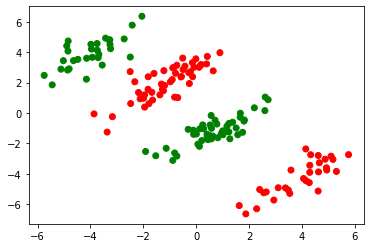

In [3]:
# 设置颜色参数
colors = {1:'r', -1:'g'}
# 绘制二分类数据集的散点图
plt.scatter(X_train[:,0], X_train[:,1], marker='o', c=pd.Series(y_train).map(colors))
plt.show();

In [4]:
### 定义高斯核函数
def gaussian_kernel(x1, x2, sigma=5.0):
    '''
    输入:
    x1: 向量1
    x2: 向量2
    输出:
    两个向量的高斯核
    '''
    return np.exp(-1 * np.linalg.norm(x1-x2)**2 / (2 * (sigma ** 2)))

In [5]:
from cvxopt import matrix, solvers

### 定义线性不可分支持向量机
### 借助于高斯核函数转化为线性可分的情形
class Non_Linear_SVM:
    ### 定义基本参数
    def __init__(self, kernel=gaussian_kernel):
        # 非线性可分svm核函数，默认为高斯核函数
        self.kernel = kernel
    
    ### 定义非线性可分支持向量机拟合方法
    def fit(self, X, y):
        # 训练样本数和特征数
        m, n = X.shape
        
        # 基于线性核计算Gram矩阵
        K = self._gram_matrix(X)
                
        # 初始化二次规划相关变量：P/q/A/b/G/h
        P = matrix(np.outer(y,y) * K)
        q = matrix(np.ones(m) * -1)
        A = matrix(y, (1, m))
        b = matrix(0.0)
        G = matrix(np.diag(np.ones(m) * -1))
        h = matrix(np.zeros(m))

        # 构建二次规划求解
        sol = solvers.qp(P, q, G, h, A, b)
        # 拉格朗日乘子
        a = np.ravel(sol['x'])

        # 寻找支持向量
        spv = a > 1e-5
        ix = np.arange(len(a))[spv]
        self.a = a[spv]
        self.spv = X[spv]
        self.spv_y = y[spv]
        print('{0} support vectors out of {1} points'.format(len(self.a), m))

        # 截距向量
        self.b = 0
        for i in range(len(self.a)):
            self.b += self.spv_y[i]
            self.b -= np.sum(self.a * self.spv_y * K[ix[i], spv])
        self.b /= len(self.a)

        # 权重向量
        self.w = None

    ### 定义Gram矩阵计算函数
    def _gram_matrix(self, X):
        m, n = X.shape
        K = np.zeros((m, m))
        # 遍历计算Gram矩阵
        for i in range(m):
            for j in range(m):
                K[i,j] = self.kernel(X[i], X[j])
        return K
    
    ### 定义映射函数
    def project(self, X):
        y_pred = np.zeros(len(X))
        for i in range(X.shape[0]):
            s = 0
            for a, spv_y, spv in zip(self.a, self.spv_y, self.spv):
                s += a * spv_y * self.kernel(X[i], spv)
            y_pred[i] = s
        return y_pred + self.b
    
    ### 定义模型预测函数
    def predict(self, X):
        return np.sign(self.project(X))

In [6]:
# 导入sklearn准确率评估函数
from sklearn.metrics import accuracy_score
# 创建非线性可分支持向量机模型实例
non_linear_svm = Non_Linear_SVM()
# 模型拟合
non_linear_svm.fit(X_train, y_train)
# 模型预测
y_pred = non_linear_svm.predict(X_test)
# 计算测试集准确率
print('Accuracy of soft margin svm based on cvxopt: ', 
      accuracy_score(y_test, y_pred))

     pcost       dcost       gap    pres   dres
 0: -5.3568e+01 -1.6420e+02  5e+02  2e+01  2e+00
 1: -8.8786e+01 -2.2857e+02  3e+02  9e+00  1e+00
 2: -1.4931e+02 -3.0498e+02  2e+02  6e+00  7e-01
 3: -2.5586e+02 -4.2288e+02  3e+02  5e+00  7e-01
 4: -3.7268e+02 -5.2110e+02  2e+02  3e+00  4e-01
 5: -4.5331e+02 -5.5961e+02  1e+02  2e-01  3e-02
 6: -5.0139e+02 -5.1044e+02  9e+00  2e-02  2e-03
 7: -5.0636e+02 -5.0698e+02  6e-01  1e-03  1e-04
 8: -5.0674e+02 -5.0675e+02  7e-03  1e-05  1e-06
 9: -5.0675e+02 -5.0675e+02  7e-05  1e-07  1e-08
10: -5.0675e+02 -5.0675e+02  7e-07  1e-09  1e-10
Optimal solution found.
9 support vectors out of 160 points
Accuracy of soft margin svm based on cvxopt:  1.0


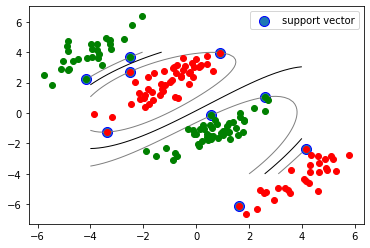

In [7]:
### 绘制非线性可分支持向量机
def plot_classifier(X1_train, X2_train, clf):
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "go")
    # plt.scatter(non_linear_svm.spv[:,0], non_linear_svm.spv[:,1], s=100, c="", edgecolors="b", label="support vector")
    plt.scatter(non_linear_svm.spv[:,0], non_linear_svm.spv[:,1], s=100, edgecolors="b", label="support vector")
    X1, X2 = np.meshgrid(np.linspace(-4,4,50), np.linspace(-4,4,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = non_linear_svm.project(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.legend()
    plt.show()
    
plot_classifier(X_train[y_train==1], X_train[y_train==-1], non_linear_svm)

In [8]:
from sklearn import svm
# 创建svm模型实例
clf = svm.SVC(kernel='rbf')
# 模型拟合
clf.fit(X_train, y_train)
# 模型预测
y_pred = clf.predict(X_test)
# 计算测试集准确率
print('Accuracy of soft margin svm based on sklearn: ', 
      accuracy_score(y_test, y_pred))

Accuracy of soft margin svm based on sklearn:  1.0
